# ABSA Fine-tuning Evaluation

This notebook evaluates our fine-tuned models against various baselines across different datasets.

In [1]:
import json
import logging
import os
import time
from collections import Counter

import matplotlib.pyplot as plt
import openai
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Model configurations
MODEL_CONFIGS = {
    "14lap": "ft:gpt-4o-2024-08-06:personal:pointerless-absa-14lap:AZfyztgA",
    "14res": "ft:gpt-4o-2024-08-06:personal:pointerless-absa-14res:AZfZteF6",
    "15res": "ft:gpt-4o-2024-08-06:personal:pointerless-absa-15res:AZfHUvGv",
    "16res": "ft:gpt-4o-2024-08-06:personal:pointerless-absa-16res:AZfNv1pA",
}

# Baselines
PAPER_BASELINE = {
    "14res": {"P": 65.52, "R": 64.99, "F1": 65.25},
    "14lap": {"P": 61.41, "R": 56.19, "F1": 58.69},
    "15res": {"P": 59.14, "R": 59.38, "F1": 59.26},
    "16res": {"P": 66.60, "R": 68.68, "F1": 67.62},
}

SOTA_BASELINE = {
    "14res": {"P": 76.1, "R": 75.08, "F1": 75.59},
    "14lap": {"P": 66.82, "R": 60.68, "F1": 63.61},
    "15res": {"P": 66.50, "R": 63.86, "F1": 65.15},
    "16res": {"P": 75.52, "R": 74.14, "F1": 74.83},
}

MY_BASELINE = {
    "14res": {"P": 0.0, "R": 0.0, "F1": 0.0},  # Placeholder values
    "14lap": {"P": 0.0, "R": 0.0, "F1": 0.0},
    "15res": {"P": 0.0, "R": 0.0, "F1": 0.0},
    "16res": {"P": 0.0, "R": 0.0, "F1": 0.0},
}

In [3]:
class ABSAMetric:
    def __init__(self):
        self.reset()

    def reset(self):
        self.ae_oe_fp = self.ae_oe_fn = self.ae_oe_tp = 0
        self.ae_sc_fp = self.ae_sc_fn = self.ae_sc_tp = 0
        self.triplet_fp = self.triplet_fn = self.triplet_tp = 0
        self.total = self.exact_matches = 0

    def update(self, pred_aspects, pred_opinions, pred_sentiments, true_aspects, true_opinions, true_sentiments):
        self.total += 1

        # Aspect + Opinion
        pred_ao = set(zip(pred_aspects, pred_opinions))
        true_ao = set(zip(true_aspects, true_opinions))
        self.ae_oe_tp += len(pred_ao & true_ao)
        self.ae_oe_fp += len(pred_ao - true_ao)
        self.ae_oe_fn += len(true_ao - pred_ao)

        # Aspect + Sentiment
        pred_as = set(zip(pred_aspects, pred_sentiments))
        true_as = set(zip(true_aspects, true_sentiments))
        self.ae_sc_tp += len(pred_as & true_as)
        self.ae_sc_fp += len(pred_as - true_as)
        self.ae_sc_fn += len(true_as - pred_as)

        # Triplet
        pred_triplets = set(zip(pred_aspects, pred_opinions, pred_sentiments))
        true_triplets = set(zip(true_aspects, true_opinions, true_sentiments))
        self.triplet_tp += len(pred_triplets & true_triplets)
        self.triplet_fp += len(pred_triplets - true_triplets)
        self.triplet_fn += len(true_triplets - pred_triplets)

        # Exact Match
        if pred_triplets == true_triplets:
            self.exact_matches += 1

    def compute_metrics(self):
        ae_oe_metrics = self._compute_f1(self.ae_oe_tp, self.ae_oe_fp, self.ae_oe_fn)
        ae_sc_metrics = self._compute_f1(self.ae_sc_tp, self.ae_sc_fp, self.ae_sc_fn)
        triplet_metrics = self._compute_f1(self.triplet_tp, self.triplet_fp, self.triplet_fn)

        return {
            "ae_oe": ae_oe_metrics,
            "ae_sc": ae_sc_metrics,
            "triplet": triplet_metrics,
            "exact_match": self.exact_matches / self.total if self.total > 0 else 0,
        }

    def _compute_f1(self, tp, fp, fn):
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return {"precision": precision, "recall": recall, "f1": f1}

In [4]:
def load_test_data(file_path):
    logger.info(f"Loading test data from {file_path}")
    with open(file_path, "r") as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} test samples")
    return data


def load_or_create_cache(cache_file):
    if os.path.exists(cache_file):
        with open(cache_file, "r") as f:
            return json.load(f)
    return {}


def save_cache(cache, cache_file):
    with open(cache_file, "w") as f:
        json.dump(cache, f, indent=2)


def get_model_prediction(text, cache, cache_file, use_cache=True):
    if use_cache and text in cache:
        return cache[text]

    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                model=MODEL_NAME,
                messages=[
                    {
                        "role": "system",
                        "content": "You are an AI trained to perform aspect-based sentiment analysis. Identify aspects, opinions, and sentiments in the given text.",
                    },
                    {"role": "user", "content": f"Perform aspect-based sentiment analysis on the following text:\n\n{text}"},
                ],
                max_tokens=150,
                n=1,
                stop=None,
                temperature=0.5,
            )
            prediction = response.choices[0].message["content"].strip()
            cache[text] = prediction
            save_cache(cache, cache_file)
            return prediction
        except Exception as e:
            logger.warning(f"Error in API call (attempt {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(2**attempt)  # Exponential backoff
            else:
                logger.error(f"Failed to get prediction after {max_retries} attempts")
                return None


def parse_prediction(prediction):
    aspects, opinions, sentiments = [], [], []
    lines = prediction.split("\n")
    # skip the first line
    lines = lines[1:]
    for line in lines:
        if ":" in line:
            parts = line.split(":")
            if len(parts) == 2:
                key, value = parts[0].strip().lower(), parts[1].strip()
                if "aspect" in key:
                    aspects.append(value)
                elif "opinion" in key:
                    opinions.append(value)
                elif "sentiment" in key:
                    sentiments.append(value)
    return aspects, opinions, sentiments


def evaluate_model(test_data, cache_file, use_cache=True):
    metric = ABSAMetric()
    cache = load_or_create_cache(cache_file)

    for sample in tqdm(test_data, desc="Evaluating", unit="sample"):
        text = sample["raw_words"]
        true_aspects = [" ".join(aspect["term"]) for aspect in sample["aspects"]]
        true_opinions = [" ".join(opinion["term"]) for opinion in sample["opinions"]]
        true_sentiments = [aspect["polarity"] for aspect in sample["aspects"]]

        print(f"Input: {text}")
        prediction = get_model_prediction(text, cache, cache_file, use_cache)
        print(f"Prediction: {prediction}")

        if prediction:
            pred_aspects, pred_opinions, pred_sentiments = parse_prediction(prediction)
            print(f"Predicted: {pred_aspects}, {pred_opinions}, {pred_sentiments}")
            print(f"True: {true_aspects}, {true_opinions}, {true_sentiments}")
            metric.update(pred_aspects, pred_opinions, pred_sentiments, true_aspects, true_opinions, true_sentiments)
        else:
            logger.warning("Failed to get a valid prediction")

    return metric.compute_metrics()

In [5]:
def create_comparison_df(results):
    """Create a DataFrame comparing our results with baselines."""
    all_data = []

    for dataset in results:
        # Our results
        our_metrics = results[dataset]["triplet"]
        all_data.append(
            {
                "Dataset": dataset,
                "Model": "GPT 4o Finetuned",
                "Precision": our_metrics["precision"] * 100,
                "Recall": our_metrics["recall"] * 100,
                "F1": our_metrics["f1"] * 100,
            }
        )

        # Paper baseline
        all_data.append(
            {
                "Dataset": dataset,
                "Model": "Paper Baseline",
                "Precision": PAPER_BASELINE[dataset]["P"],
                "Recall": PAPER_BASELINE[dataset]["R"],
                "F1": PAPER_BASELINE[dataset]["F1"],
            }
        )

        # SOTA baseline
        all_data.append(
            {
                "Dataset": dataset,
                "Model": "SOTA",
                "Precision": SOTA_BASELINE[dataset]["P"],
                "Recall": SOTA_BASELINE[dataset]["R"],
                "F1": SOTA_BASELINE[dataset]["F1"],
            }
        )

        # # My baseline
        # all_data.append(
        #     {
        #         "Dataset": dataset,
        #         "Model": "My Baseline",
        #         "Precision": MY_BASELINE[dataset]["P"],
        #         "Recall": MY_BASELINE[dataset]["R"],
        #         "F1": MY_BASELINE[dataset]["F1"],
        #     }
        # )

    return pd.DataFrame(all_data)


def plot_comparison(df, metric="F1"):
    """Plot comparison of models across datasets for a given metric."""
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Dataset", y=metric, hue="Model")
    plt.title(f"Comparison of {metric} Scores Across Models and Datasets")
    plt.ylabel(f"{metric} Score")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [6]:
def evaluate_all_models():
    # Get location of jupyter notebook
    notebook_path = os.getcwd()
    data_path = os.path.dirname(notebook_path)
    annotator = "pengb"
    results = {}

    for dataset in MODEL_CONFIGS:
        logger.info(f"\nEvaluating dataset: {dataset}")

        # Set up paths
        test_file = f"{data_path}/absa/{annotator}/json/{dataset}/test.json"
        cache_file = f"{data_path}/finetuning/{annotator}/{dataset}/prediction_cache.json"
        results_file = f"{data_path}/finetuning/{annotator}/{dataset}/evaluation_results.json"

        # Load test data
        test_data = load_test_data(test_file)

        # Set model name
        global MODEL_NAME
        MODEL_NAME = MODEL_CONFIGS[dataset]

        # Evaluate
        metrics = evaluate_model(test_data, cache_file, use_cache=True)
        results[dataset] = metrics

        # Save individual results
        with open(results_file, "w") as f:
            json.dump(metrics, f, indent=2)

    return results

In [7]:
# Run evaluation
results = evaluate_all_models()

# Create comparison DataFrame
comparison_df = create_comparison_df(results)   

2024-12-01 19:15:23,762 - INFO - 
Evaluating dataset: 14lap
2024-12-01 19:15:23,763 - INFO - Loading test data from /Users/tomvolker/localProjects/ba/absa/data/absa/pengb/json/14lap/test.json
2024-12-01 19:15:23,766 - INFO - Loaded 328 test samples
Evaluating: 100%|██████████| 328/328 [00:00<00:00, 70431.15sample/s]
2024-12-01 19:15:23,788 - INFO - 
Evaluating dataset: 14res
2024-12-01 19:15:23,788 - INFO - Loading test data from /Users/tomvolker/localProjects/ba/absa/data/absa/pengb/json/14res/test.json
2024-12-01 19:15:23,791 - INFO - Loaded 492 test samples


Input: Boot time is super fast , around anywhere from 35 seconds to 1 minute .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Boot time
Opinion: super fast
Sentiment: POS
Predicted: ['Boot time'], ['super fast'], ['POS']
True: ['Boot time'], ['fast'], ['POS']
Input: tech support would not fix the problem unless I bought your plan for $ 150 plus .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: tech support
Opinion: not fix
Sentiment: NEG

Aspect: plan
Opinion: $ 150 plus
Sentiment: NEG
Predicted: ['tech support', 'plan'], ['not fix', '$ 150 plus'], ['NEG', 'NEG']
True: ['tech support'], ['not fix'], ['NEG']
Input: Set up was easy .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Set up
Opinion: easy
Sentiment: POS
Predicted: ['Set up'], ['easy'], ['POS']
True: ['Set up'], ['easy'], ['POS']
Input: Did not enjoy the new Windows 8 and touchscreen functions .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Windows 8
Opini

Evaluating: 100%|██████████| 492/492 [00:00<00:00, 16892.17sample/s]
2024-12-01 19:15:23,856 - INFO - 
Evaluating dataset: 15res
2024-12-01 19:15:23,856 - INFO - Loading test data from /Users/tomvolker/localProjects/ba/absa/data/absa/pengb/json/15res/test.json
2024-12-01 19:15:23,859 - INFO - Loaded 322 test samples


Input: The bread is top notch as well .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: bread
Opinion: top notch
Sentiment: POS
Predicted: ['bread'], ['top notch'], ['POS']
True: ['bread'], ['top notch'], ['POS']
Input: I have to say they have one of the fastest delivery times in the city .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: delivery times
Opinion: fastest
Sentiment: POS
Predicted: ['delivery times'], ['fastest'], ['POS']
True: ['delivery times'], ['fastest'], ['POS']
Input: Food is always fresh and hot ready to eat !
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Food
Opinion: fresh
Sentiment: POS

Aspect: Food
Opinion: hot
Sentiment: POS
Predicted: ['Food', 'Food'], ['fresh', 'hot'], ['POS', 'POS']
True: ['Food', 'Food'], ['fresh', 'hot'], ['POS', 'POS']
Input: Did I mention that the coffee is OUTSTANDING ?
Prediction: Here's the aspect-based sentiment analysis:

Aspect: coffee
Opinion: OUTSTANDING
Sentiment: POS
Predic

Evaluating: 100%|██████████| 322/322 [00:00<00:00, 30411.99sample/s]
2024-12-01 19:15:23,880 - INFO - 
Evaluating dataset: 16res
2024-12-01 19:15:23,880 - INFO - Loading test data from /Users/tomvolker/localProjects/ba/absa/data/absa/pengb/json/16res/test.json
2024-12-01 19:15:23,882 - INFO - Loaded 326 test samples


Input: Love Al Di La
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Al Di La
Opinion: Love
Sentiment: POS
Predicted: ['Al Di La'], ['Love'], ['POS']
True: ['Al Di La'], ['Love'], ['POS']
Input: I recommend this place to everyone .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: place
Opinion: recommend
Sentiment: POS
Predicted: ['place'], ['recommend'], ['POS']
True: ['place'], ['recommend'], ['POS']
Input: Great food .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: food
Opinion: Great
Sentiment: POS
Predicted: ['food'], ['Great'], ['POS']
True: ['food'], ['Great'], ['POS']
Input: The pastas are incredible , the risottos ( particularly the sepia ) are fantastic and the braised rabbit is amazing .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: pastas
Opinion: incredible
Sentiment: POS

Aspect: risottos ( particularly the sepia )
Opinion: fantastic
Sentiment: POS

Aspect: braised rabbit
Opinion: amazing
Sentiment: POS

Evaluating: 100%|██████████| 326/326 [00:00<00:00, 80003.69sample/s]

Input: Serves really good sushi .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: sushi
Opinion: good
Sentiment: POS
Predicted: ['sushi'], ['good'], ['POS']
True: ['sushi'], ['good'], ['POS']
Input: Not the biggest portions but adequate .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: portions
Opinion: Not the biggest
Sentiment: NEU

Aspect: portions
Opinion: adequate
Sentiment: POS
Predicted: ['portions', 'portions'], ['Not the biggest', 'adequate'], ['NEU', 'POS']
True: ['portions', 'portions'], ['Not the biggest', 'adequate'], ['NEU', 'NEU']
Input: Green Tea creme brulee is a must !
Prediction: Here's the aspect-based sentiment analysis:

Aspect: Green Tea creme brulee
Opinion: must
Sentiment: POS
Predicted: ['Green Tea creme brulee'], ['must'], ['POS']
True: ['Green Tea creme brulee'], ['must'], ['POS']
Input: It has great sushi and even better service .
Prediction: Here's the aspect-based sentiment analysis:

Aspect: sushi
Opinion: great
Sentimen


Detailed Results:
   Dataset             Model  Precision     Recall         F1
0    14lap  GPT 4o Finetuned  61.666667  68.391867  64.855390
1    14lap    Paper Baseline  61.410000  56.190000  58.690000
2    14lap              SOTA  66.820000  60.680000  63.610000
3    14res  GPT 4o Finetuned  74.645222  79.376258  76.938079
4    14res    Paper Baseline  65.520000  64.990000  65.250000
5    14res              SOTA  76.100000  75.080000  75.590000
6    15res  GPT 4o Finetuned  61.913043  73.402062  67.169811
7    15res    Paper Baseline  59.140000  59.380000  59.260000
8    15res              SOTA  66.500000  63.860000  65.150000
9    16res  GPT 4o Finetuned  71.378092  78.599222  74.814815
10   16res    Paper Baseline  66.600000  68.680000  67.620000
11   16res              SOTA  75.520000  74.140000  74.830000


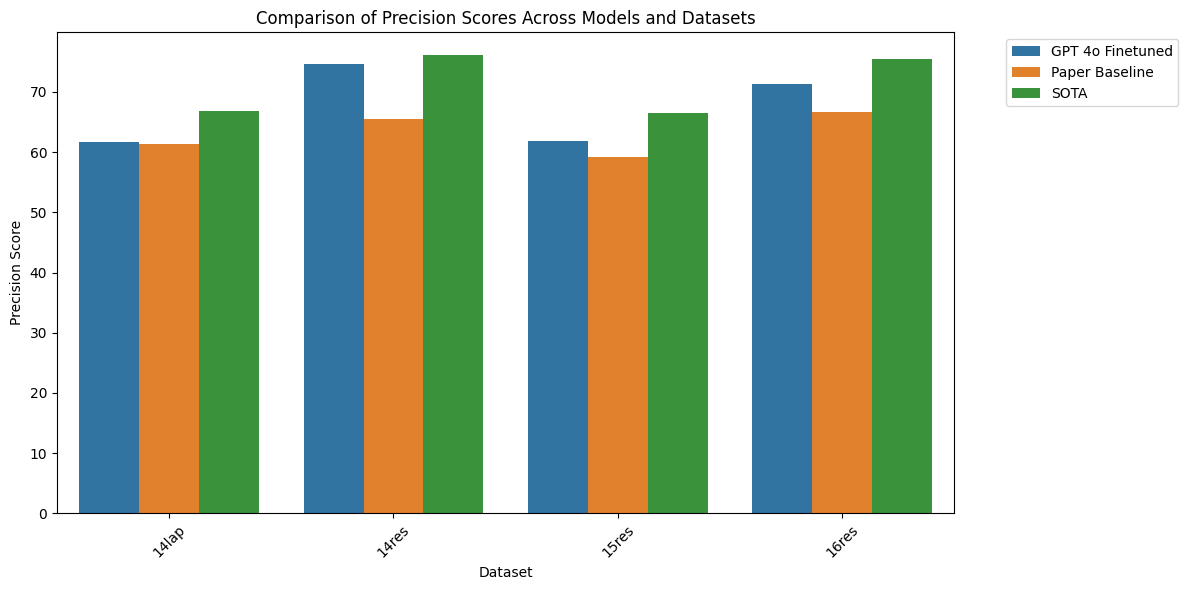

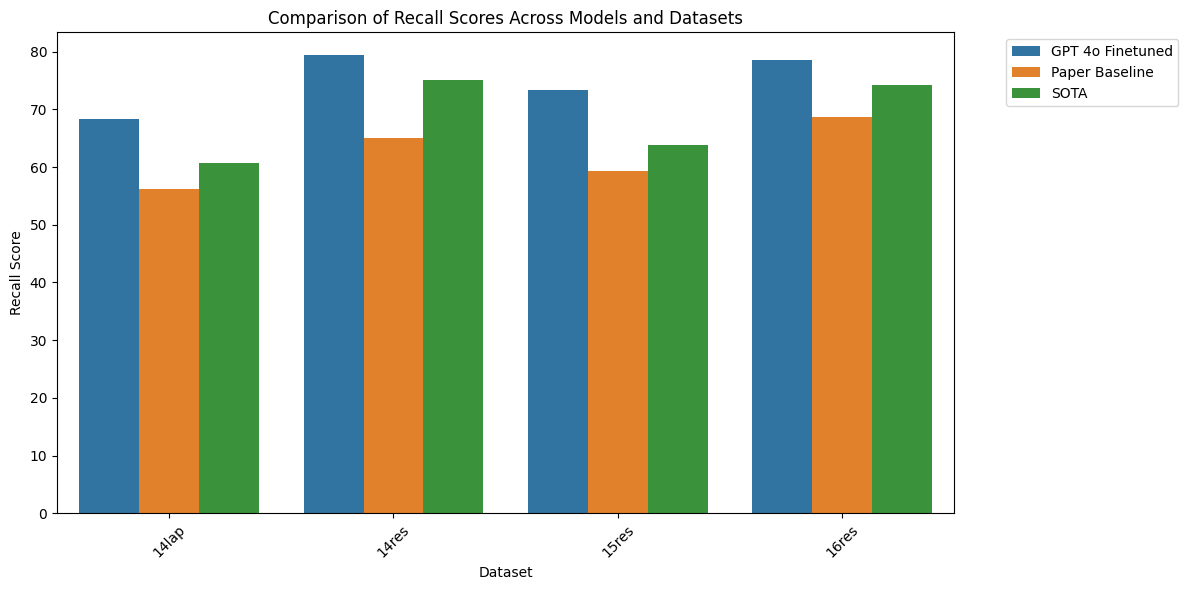

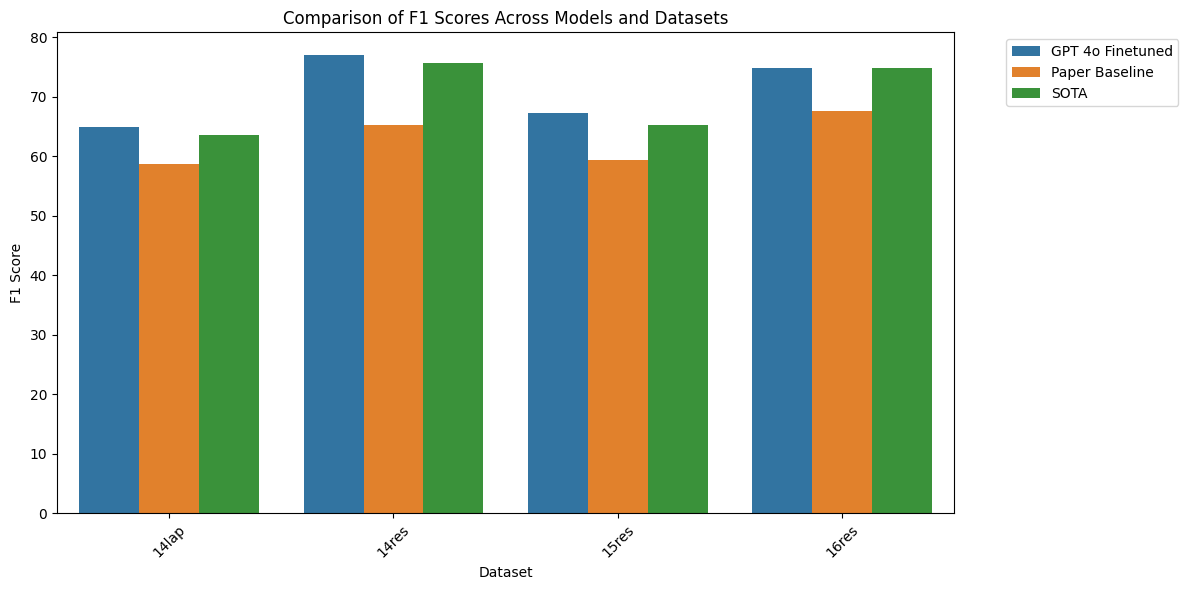

In [8]:
# Display results table
print("\nDetailed Results:")
print(comparison_df.to_string())

# Plot comparisons
for metric in ["Precision", "Recall", "F1"]:
    plot_comparison(comparison_df, metric)

# Save results
# comparison_df.to_csv("evaluation_comparison.csv", index=False)